# Crunchyroll Exploratory Data Analysis

## Useful Functions

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import seaborn as sns
import random

def explode(df, lst_cols, fill_value=''):
    # make sure `lst_cols` is a list
    if lst_cols and not isinstance(lst_cols, list):
        lst_cols = [lst_cols]
    # all columns except `lst_cols`
    idx_cols = df.columns.difference(lst_cols)

    # calculate lengths of lists
    lens = df[lst_cols[0]].str.len()

    if (lens > 0).all():
        # ALL lists in cells aren't empty
        return pd.DataFrame({
            col:np.repeat(df[col].values, lens)
            for col in idx_cols
        }).assign(**{col:np.concatenate(df[col].values) for col in lst_cols}) \
          .loc[:, df.columns]
    else:
        # at least one list in cells is empty
        return pd.DataFrame({
            col:np.repeat(df[col].values, lens)
            for col in idx_cols
        }).assign(**{col:np.concatenate(df[col].values) for col in lst_cols}) \
          .append(df.loc[lens==0, idx_cols]).fillna(fill_value) \
          .loc[:, df.columns]
    
def clean_data(df, *argv):
    df1 = df.copy()
    for series in argv:
        df1[series] = df1[series].str.lower()
        df1[series] = df1[series].str.replace("\n","")
        df1[series] = df1[series].str.replace("\r","")
        df1[series] = df1[series].str.replace("-"," ")
        df1[series] = df1[series].str.replace("[^\w\s]","")
        df1[series] = df1[series].str.strip()
    df1 = df1.fillna("None")
    df1 = df1.replace("", "missing")
    return df1

def top_n(df, n, series):
    return df.sort_values(series, ascending = False).iloc[:n]


## Import and Clean Data

In [3]:
home = pd.read_csv("https://raw.githubusercontent.com/ayakkala1/Data301/master/crunchyroll/crunchy_home.csv")

home["similar"] = home["similar"].apply(lambda x: x.split("::"))
home["tags"] = home["tags"].apply(lambda x: x.split("::"))
home["agg_rating"] = ((home["1"] + home["2"] * 2 + home["3"] * 3 + home["4"] * 4 + home["5"] * 5)/
                        home[["1","2","3","4","5"]].sum(axis = 1))

home["name"] = home["name"].str.replace("-"," ").str.lower()

reviews = pd.read_csv("https://raw.githubusercontent.com/ayakkala1/Data301/master/crunchyroll/crunchy_review.csv")

main = pd.read_csv("https://raw.githubusercontent.com/ayakkala1/Data301/master/crunchyroll/crunchy_main.csv")

main["similar"] = main["similar"].apply(lambda x: x.split("::"))
main["tags"] = main["tags"].apply(lambda x: x.split("::"))
main["name"] = main["name"].str.replace("-"," ").str.lower()


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Merge myanimelist

We merge our Crunchyroll dataset with another [Kaggle Dataset](https://www.kaggle.com/CooperUnion/anime-recommendations-database) that includes more info about our shows from a website, https://myanimelist.net/. With this we now have access to the Age groups of the Animes, their genre definition of the show, & show runtime dates.

In [5]:
animelist = clean_data(pd.read_csv("/Volumes/SD_Card/myanimelist/AnimeList.csv"),"title", "title_english")
animelist = animelist[animelist["type"] == "TV"]

Seperate the show run time dates to seperate columns.

In [6]:
animelist["from"] = animelist["aired"].apply(lambda x : dict(eval(x))).apply(pd.Series)["from"]
animelist["to"] = animelist["aired"].apply(lambda x : dict(eval(x))).apply(pd.Series)["to"]

We know merge the datasets together

In [7]:
merge_anime  = home.merge(animelist[["title_english","title",
                                     "rating","duration",
                                     "from","to","genre"]],how = "inner", left_on="name",
          right_on="title_english")

### Average Rating of Age Groups for the Animes

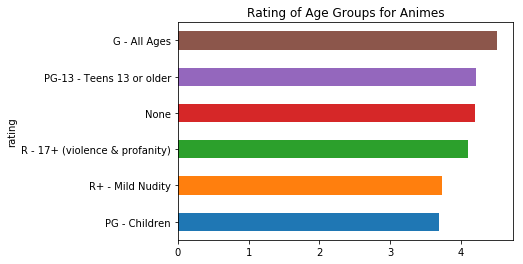

In [8]:
(merge_anime.pivot_table(index = "rating",values="agg_rating",aggfunc=np.mean).reset_index().
 sort_values("agg_rating").
 plot.barh(x="rating",y="agg_rating", title = "Rating of Age Groups for Animes")).get_legend().remove()

### Top Anime Genre Trends Since the 2000's

Let's merge the myanimelist dataset with our main dataset.

In [9]:
merge_anime_main = main.merge(animelist[["title_english","title","rating","duration","from","to","genre"]],
                              how = "inner", 
                              left_on="name",
                   right_on="title_english")

merge_anime_main["from"] = pd.to_datetime(merge_anime_main["from"])
merge_anime_main["to"] = pd.to_datetime(merge_anime_main["to"])

In [10]:
merge_anime_main["year"] = merge_anime_main["from"].apply(lambda x : x.year)

merge_anime_main["genre"] = merge_anime_main["genre"].str.split(",")

Now let's get it so that each column is a genre  with it's year

In [202]:
genresbyyear = explode(merge_anime_main[["genre","year"]],"genre")
genresbyyear["genre"] = genresbyyear["genre"].str.strip()

genresbyyear.head()

,genre,year
0,Action,2009.0
1,Demons,2009.0
2,Fantasy,2009.0
3,Josei,2009.0
4,Magic,2009.0


Let's crosstab that so we get the counts of each genre per year

In [203]:
genre_year_cross = pd.crosstab(index=genresbyyear['year'], columns=genresbyyear['genre'])

genre_year_cross.head()

genre,Action,Adventure,Comedy,Dementia,Demons,Drama,Ecchi,Fantasy,Game,Harem,...,Shoujo Ai,Shounen,Shounen Ai,Slice of Life,Space,Sports,Super Power,Supernatural,Thriller,Vampire
year,,,,,,,,,,,,,,,,,,,,,
1967.0,4,0,0,0,0,0,0,4,0,0,...,0,0,0,0,0,0,0,0,0,0
1981.0,1,0,5,0,0,0,5,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1984.0,34,5,3,0,0,29,0,0,0,0,...,0,29,0,0,0,0,0,0,0,0
1990.0,8,0,8,0,0,0,0,0,0,0,...,0,8,0,0,0,0,8,0,0,0
1993.0,0,0,32,0,0,32,0,0,0,0,...,0,32,0,0,0,32,0,0,0,0


It would be too much to graph every genre so let's just take a look at the top 6 genre's and call everything "other".

In [12]:
top_6_genre = genresbyyear["genre"].value_counts().iloc[:7].index

top_6_genre

Index(['Action', 'Comedy', 'Romance', 'Fantasy', 'Shounen', 'School',
       'Adventure'],
      dtype='object')

We have to use Regex to easily map every other value to 'Other'

In [13]:
genresbyyear_ = (genresbyyear.replace(to_replace=r'^(?!(Action|Comedy|Romance|Fantasy|Shounen|School)$).*$',
                                      value='Other',
                                      regex=True))

Let's normalize by year so we can get the proportions of the genre in that year.

In [14]:
genresbyyear_cross = pd.crosstab(index=genresbyyear_['year'], columns=genresbyyear_['genre'])

In [15]:
year_genre_post2000 = genresbyyear_cross.divide(genresbyyear_cross.sum(axis = 1),axis = 0).loc[2000:]

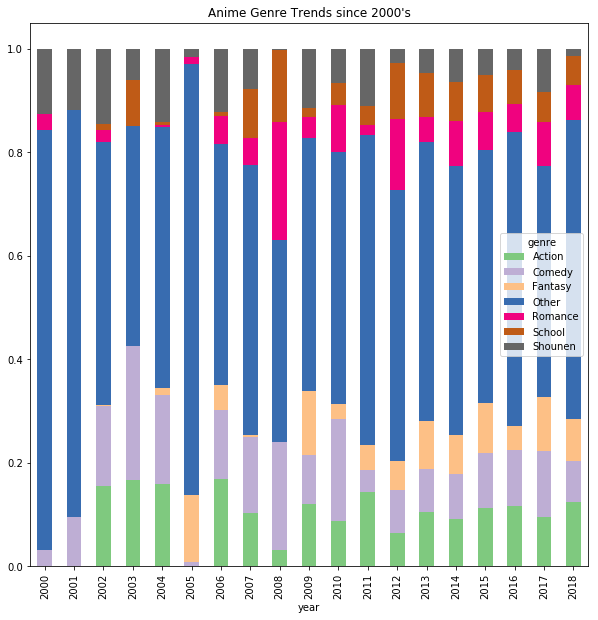

In [16]:
year_genre_post2000.index = year_genre_post2000.index.astype("int64")

year_genre_post2000.plot(kind='bar',
                         stacked = True,
                         figsize=(10,10),
                         colormap="Accent",
                        title = "Anime Genre Trends since 2000's")

## Shows that are most said to be similar

In [17]:
similars = explode(pd.DataFrame(home["similar"]),"similar")

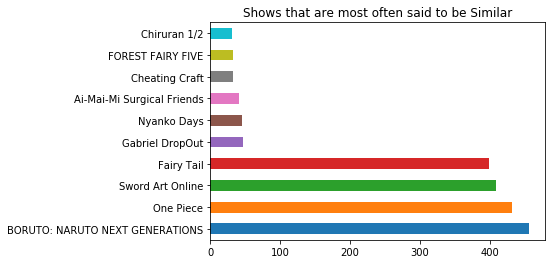

In [208]:
similars["similar"].value_counts()[:10].plot.barh(title="Shows that are most often said to be Similar")

## TAGS

### Most Common

In [19]:
tags = explode(home,"tags")

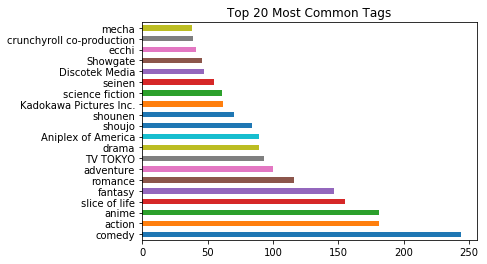

In [210]:
tags["tags"].value_counts().iloc[:20].plot.barh(title= "Top 20 Most Common Tags")

### Props of 1 Ratings

In [24]:
tags_numvals = (explode(home,"tags").
                pivot_table(index="tags",
                            values=["1", "2", "3", "4", "5"],
                            aggfunc=np.sum))

In [25]:
tags_numvals["total"] = tags_numvals.sum(axis = 1)

Let's look at the just the top 100 tags

In [26]:
top_tags = top_n(tags_numvals, 100, "total")

In [214]:
top_tags_norm = (top_tags[["1","2","3","4","5"]].divide(top_tags["total"],axis = 0).
                 join(top_tags["total"]))

top_tags_norm.head()

,1,2,3,4,5,total
tags,,,,,,
anime,0.019040,0.007806,0.025447,0.086360,0.861347,295797.0
TV TOKYO,0.019753,0.007109,0.020024,0.067422,0.885693,206505.0
comedy,0.019057,0.012089,0.032543,0.110800,0.825511,117383.0
romance,0.022719,0.014877,0.034552,0.106914,0.820938,79185.0
drama,0.018825,0.010247,0.027999,0.095765,0.847163,73680.0


Now of that top 100 lets plot the top 10 tags with the highest proportion of 1 star ratings.

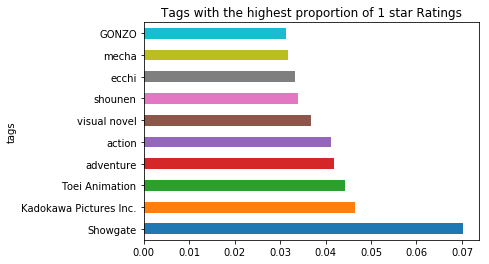

In [213]:
(top_n( top_n( top_tags_norm, 100, "total"), 10, "1")["1"]
 .plot.barh(title="Tags with the highest proportion of"
                 " 1 star Ratings"))

Instead of just looking at the explicit counts of the 1,2,3,4, and 5 star Ratings. Lets see which tags have the highest aggregate rating, having computed it before.

In [30]:
tags_agg_rating = tags.pivot_table(index="tags", 
                 values="agg_rating", 
                 aggfunc=[np.mean,'count'])

In [31]:
top20tags = top_n(tags_agg_rating["count"],20, "agg_rating").index

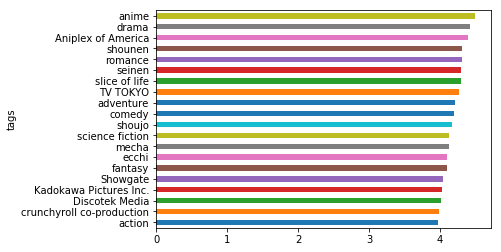

In [32]:
(tags_agg_rating["mean"].loc[top20tags].sort_values("agg_rating").
 reset_index().
 plot.barh("tags","agg_rating")).get_legend().remove()

## Reviews

## Useful Functions

In [124]:
import re
import nltk
stop_words = nltk.corpus.stopwords.words('english')

def normalize_document(doc,arg = None):
    # lower case and remove special characters\whitespaces
    doc = re.sub(r'[^a-zA-Z\s]', '', doc)
    doc = doc.replace("\r","")
    doc = doc.replace("\n","")
    doc = doc.replace("-"," ")
    doc = doc.replace("'","")
    doc = doc.lower()
    doc = doc.strip()
    tokens = tokenize(doc)
    filtered_tokens = [token for token in tokens if token not in stop_words]

    if arg == "bigrams":
        return get_bigrams(filtered_tokens)
    if arg == "trigrams":
        return get_trigrams(filtered_tokens)
    doc = ' '.join(filtered_tokens)
    return doc

def top_words(df1, quant, mode = "greater",bigram = False, description = True):
    df = df1.copy()
    df = df[df["rating"] != "No Rating"]
    df["rating"] = df["rating"].astype("float64")
    if description:
        filter_on = "review"
    else:
        filter_on = "summary"
    if mode == "greater":
        if bigram:
            words = pd.DataFrame(tokenize(df[df["rating"] >= quant][filter_on], 2))
        else:
            words = pd.DataFrame(tokenize(df[df["rating"] >= quant][filter_on]))
    elif mode == "less":
        if bigram:
            words = pd.DataFrame(tokenize(df[df["rating"] <= quant][filter_on], 2))
        else:
            words = pd.DataFrame(tokenize(df[df["rating"] <= quant][filter_on]))
    if bigram:
        return words["review"].apply(pd.Series).melt()["value"]
    else:
        tokens = explode(words,"review")
        return tokens["review"]

def get_trigrams(words):
    return list(zip(words[:-2], words[1:-1],words[2:]))

def get_quadgrams(words):
    return list(zip(words[:-2], words[1:-1],words[2:],words[3:]))

def get_bigrams(words):
    return list(zip(words[:-2], words[1:-1]))

def tokenize(text_series, gram = 1, use_stop = True):
    text_series = text_series.str.lower()

    token_list = text_series.str.replace("[^\w\s]","")
    sw = stop_words
    if use_stop:
        token_list = text_series.apply(lambda row: [word for word in row.split() if word not in sw])
    else:
        token_list = text_series.apply(lambda row: [word for word in row.split()])
    if gram == 2:
        token_list = token_list[token_list.apply(len) >= 2]
        token_list = token_list.apply(lambda x : zip(x[:-1], x[1:])).apply(list)
        return token_list
    return token_list

### Lower Half Reviews vs Higher Half Reviews

We first get the value counts for the words that appear in less than $2.5$ stars and greater than $2.5$ stars.

In [34]:
less_than_half = top_words(reviews,2.5, "less")
greater_than_half = top_words(reviews, 2.5)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


Let's do an outer merge on the two and see the differences in word counts.

In [35]:
top_small_uni = pd.DataFrame(less_than_half.value_counts()).merge(pd.DataFrame(greater_than_half.value_counts())
                                               ,how='outer',
                                               left_index=True, right_index=True)
top_small_uni = top_small_uni.fillna(0)
top_small_uni["per_x"] = top_small_uni["review_x"]/top_small_uni["review_x"].sum()
top_small_uni["per_y"] = top_small_uni["review_y"]/top_small_uni["review_y"].sum()
top_small_uni["diff"] = top_small_uni["review_x"] - top_small_uni["review_y"]
top_small_uni["per_diff"] = top_small_uni["per_x"] - top_small_uni["per_y"]

Let's see the values that occur a lot more in the lower half compared to the higher half.

In [36]:
top_small_uni.sort_values("per_diff",ascending=False).head()

,review_x,review_y,per_x,per_y,diff,per_diff
bad,1300.0,3029.0,0.004564,0.001427,-1729.0,0.003137
plot,1709.0,8028.0,0.006000,0.003783,-6319.0,0.002217
nothing,893.0,2213.0,0.003135,0.001043,-1320.0,0.002092
even,1528.0,7342.0,0.005364,0.003459,-5814.0,0.001905
episode,2516.0,14928.0,0.008833,0.007034,-12412.0,0.001799


Now vice versa...

In [37]:
top_small_uni.sort_values("per_diff",ascending=False).tail()

,review_x,review_y,per_x,per_y,diff,per_diff
amazing,191.0,7049.0,0.000671,0.003321,-6858.0,-0.002651
one,2100.0,21467.0,0.007372,0.010115,-19367.0,-0.002742
great,777.0,13598.0,0.002728,0.006407,-12821.0,-0.003679
love,610.0,16124.0,0.002142,0.007597,-15514.0,-0.005456
anime,5478.0,56871.0,0.019232,0.026797,-51393.0,-0.007565


In order to visualize the words that appear a lot more in the lower half compared to the higher half and vice versa, we opt in to use a Word Cloud. However the normal wordcloud in Python strictly uses Word Counts, which is the incorrect metric. To use our Per_Diff values as the weights we need to make than an integer and use a website that allows us to manually input the values.

We use https://www.wordclouds.com/

In [38]:
top_small_uni["round_diff"] = ((top_small_uni.sort_values("per_diff",ascending=False))
                             ["per_diff"] * 10000).astype("int64")

### Words that occur more frequently in Higher Half Words Compared to Lower Half

To get the top 40 values for the Higher Half.

`top_small_uni.sort_values("per_diff",ascending=False).reset_index().set_index("round_diff")["index"].iloc[-40:]`

<img src="images/higherhalfcloud.png">

### Words that occur more frequently in Lower Half Words Compared to Higher Half

To get the top 40 values for the Higher Half.

`top_small_uni.sort_values("per_diff",ascending=False).reset_index().set_index("round_diff")["index"].iloc[:40]`

<img src="images/lowerhalfcloud.png">

We can mimic this analysis for bigrams.

In [39]:
less_than_half_bi = top_words(reviews,2.5, "less",True)
greater_than_half_bi = top_words(reviews, 2.5, "greater", True)

In [40]:
top_small_bi = pd.DataFrame(less_than_half_bi.value_counts()).merge(pd.DataFrame(greater_than_half_bi.value_counts())
                                               ,how='outer',
                                               left_index=True, right_index=True)
top_small_bi = top_small_bi.fillna(0)
top_small_bi["per_x"] = top_small_bi["value_x"]/top_small_bi["value_x"].sum()
top_small_bi["per_y"] = top_small_bi["value_y"]/top_small_bi["value_y"].sum()
top_small_bi["diff"] = top_small_bi["value_x"] - top_small_bi["value_y"]
top_small_bi["per_diff"] = top_small_bi["per_x"] - top_small_bi["per_y"]

#### Bigrams that occur more frequently in Lower Half Words Compared to Higher Half


In [41]:
top_small_bi.sort_values("per_diff",ascending=False).head()

,value_x,value_y,per_x,per_y,diff,per_diff
"(main, character)",731.0,3092.0,0.002644,0.001503,-2361.0,0.001141
"(waste, time)",228.0,126.0,0.000825,0.000061,102.0,0.000763
"(first, episode)",725.0,3924.0,0.002622,0.001907,-3199.0,0.000715
"(filler, filler)",121.0,6.0,0.000438,0.000003,115.0,0.000435
"(feels, like)",146.0,475.0,0.000528,0.000231,-329.0,0.000297


#### Bigrams that occur more frequently in Higher Half Words Compared to Lower Half


In [42]:
top_small_bi.sort_values("per_diff",ascending=False).tail()

,value_x,value_y,per_x,per_y,diff,per_diff
"(highly, recommend)",16.0,1080.0,0.000058,0.000525,-1064.0,-0.000467
"(best, anime)",20.0,1413.0,0.000072,0.000687,-1393.0,-0.000614
"(love, anime)",26.0,1495.0,0.000094,0.000727,-1469.0,-0.000633
"(cant, wait)",6.0,1816.0,0.000022,0.000883,-1810.0,-0.000861
"(one, best)",27.0,2123.0,0.000098,0.001032,-2096.0,-0.000934


### Sentiment and Rating Over Time for Top 5 Shows

First let's get our datetime column into a date object

In [43]:
clean_reviews = clean_data(reviews,"review","summary","useful")

clean_reviews["datetime"] = clean_reviews["datetime"]. \
                            str.replace("\n", ""). \
                            str.strip()

clean_reviews["datetime"] = pd.to_datetime(clean_reviews['datetime'],
                                           format='%b %d, %Y')

Now let's tidy up the data by making it so each token is made into a row.

In [45]:
clean_reviews["tokens"] = tokenize(clean_reviews["review"])

review_tokens = clean_reviews["tokens"].apply(pd.Series) \
                .merge(clean_reviews, left_index = True, right_index = True) \
                .drop(["tokens"], axis = 1) \
                .melt(id_vars = ['show', 'datetime'], value_name = "tokens") \
                .drop("variable", axis = 1) \
                .dropna()

In [216]:
review_tokens.head()

,show,datetime,tokens
0,07-ghost,2014-09-19,clue
1,07-ghost,2013-07-27,synopsis
2,07-ghost,2012-08-03,really
3,07-ghost,2015-02-22,first
4,07-ghost,2013-01-27,well


It is very expensive to use libraries like NLTK or Spacy to provide Sentiment values for your tokens. So we opt in to using a Lexicon called [AFINN](http://www2.imm.dtu.dk/pubdb/views/publication_details.php?id=6010). Which assigns words a value from $[-5,5]$. Negative values indicate negative sentiment and positive values indicate positive sentiment. The closer the value is to $0$ the more neutral it is. $0$ being totally neutral.

In [47]:
AFINN = pd.read_csv("AFINN/AFINN-111.txt", 
                    header = None, 
                    sep="\t", 
                    names = ["words","sentiment"])

Let's join the dataset with an inner merge, since we only care for the words that are actually given a sentiment value.

In [48]:
tokens_afinn = pd.merge(review_tokens,
                       AFINN,
                       how="inner",
                       left_on="tokens",
                       right_on="words",
                       validate="many_to_one")

Now let's get the top 5 shows in terms of reviews.

In [50]:
top_5_reviews = reviews["show"].value_counts().index[:5]

In [217]:
top_5_reviews

Index(['black-clover', 'attack-on-titan', 'sword-art-online',
       'naruto-shippuden', 'hunter-x-hunter'],
      dtype='object')

Now let's group by datetime and show and get the general sentiment for that day's reviews for that show.

In [51]:
top_5_reviews_sent_a = tokens_afinn.pivot_table(index=["datetime"],
                        columns="show",
                        values="sentiment",aggfunc=np.sum)[top_5_reviews]

In [218]:
top_5_reviews_sent_a.head()

show,black-clover,attack-on-titan,sword-art-online,naruto-shippuden,hunter-x-hunter
datetime,,,,,
2009-05-19,NaN,NaN,NaN,NaN,NaN
2009-05-20,NaN,NaN,NaN,15.0,NaN
2009-05-21,NaN,NaN,NaN,NaN,NaN
2009-05-22,NaN,NaN,NaN,NaN,NaN
2009-05-23,NaN,NaN,NaN,NaN,NaN


Don't worry about the NaN's. It means that it wasn't rating that day. It is better than having a 0 since 0 will make the graph look messy, since it will anchor our points down.

At the same time let's group by datetime and show and get the average star rating for that day's reviews for that show.

In [52]:
has_rating = clean_reviews[clean_reviews["rating"] != "No Rating"]
has_rating["rating"] = has_rating["rating"].astype("float64")

top_5_reviews_rating = has_rating.pivot_table(index=["datetime"],
                        columns="show",
                        values="rating",aggfunc=np.mean)[top_5_reviews]

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [219]:
top_5_reviews_rating.head()

show,black-clover,attack-on-titan,sword-art-online,naruto-shippuden,hunter-x-hunter
datetime,,,,,
2009-05-19,NaN,NaN,NaN,NaN,NaN
2009-05-20,NaN,NaN,NaN,4.5,NaN
2009-05-21,NaN,NaN,NaN,NaN,NaN
2009-05-22,NaN,NaN,NaN,NaN,NaN
2009-05-23,NaN,NaN,NaN,NaN,NaN


We now melt the dataframes such that each row is a day.

In [53]:
top_5_reviews_sent_gather = pd.melt(top_5_reviews_sent_a.reset_index(),
                                    "datetime",
                                     value_vars=top_5_reviews_sent_a.columns)

top_5_reviews_rating_gather = pd.melt(top_5_reviews_rating.reset_index(),
                                    "datetime",
                                     value_vars=top_5_reviews_sent_a.columns)

Since `matplotlib` works messily with dateobjects we have to convert the datetime values to numeric values.

In [ ]:
from datetime import datetime

In [54]:
top_5_reviews_sent_gather["date_ord"] = (pd.to_datetime(top_5_reviews_sent_gather['datetime']).
                                             apply(lambda date: date.toordinal()))

Now to graphing the Sentiment over Time for each show's reviews.

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


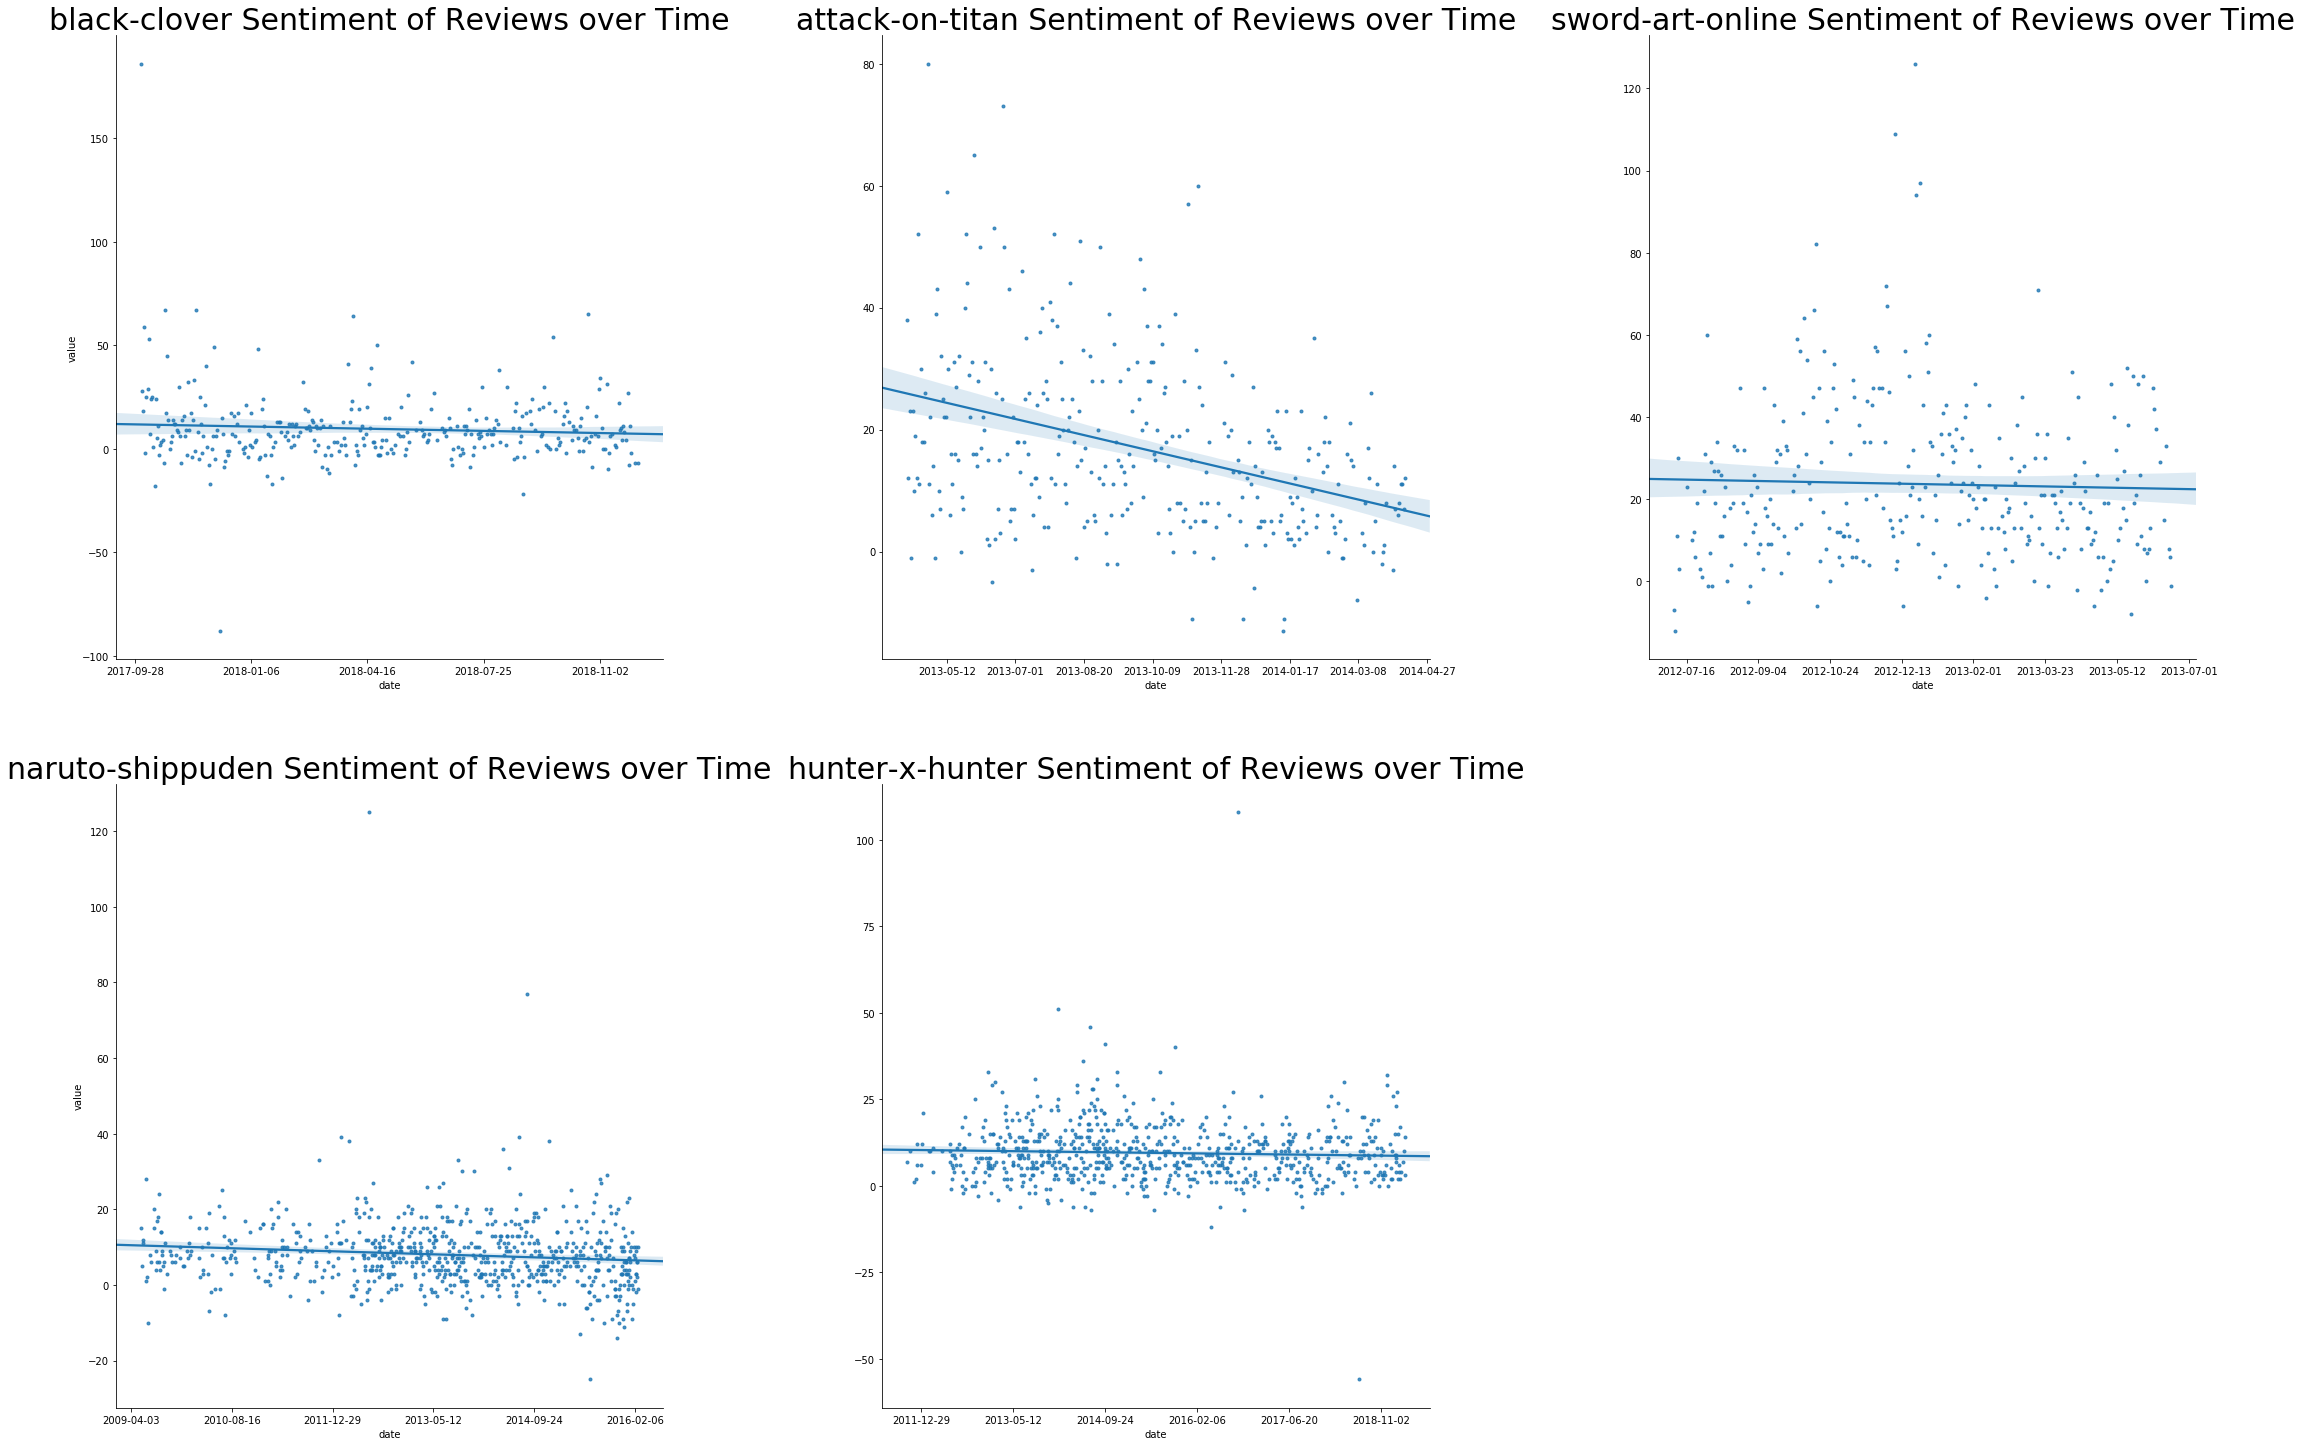

In [56]:
import matplotlib.pyplot as plt
g = sns.FacetGrid(top_5_reviews_sent_gather, 
                  col="show", 
                  col_wrap=3, 
                  height=10,
                  aspect = 1,
                  sharex = False, 
                  sharey=False)

g = g.map(sns.regplot,
          "date_ord",
          "value",
          marker = ".").set_titles("{col_name} Sentiment of Reviews over Time",size = 30)

for ax in g.axes.flat:
    ax.set_xlabel('date')
    new_labels = [datetime.fromordinal(int(item)).date() for item in ax.get_xticks()]
    ax.set_xticklabels(new_labels)

plt.subplots_adjust(hspace=0.2, wspace=0.4)
plt.show()


It appears that there is a slight trend down for all shows except for Hunter X Hunter, but quite noticably for Attack on Titan.

Let's now do the same but for Rating

In [57]:
top_5_reviews_rating_gather["date_ord"] = (pd.to_datetime(top_5_reviews_rating_gather['datetime']).
                                             apply(lambda date: date.toordinal()))

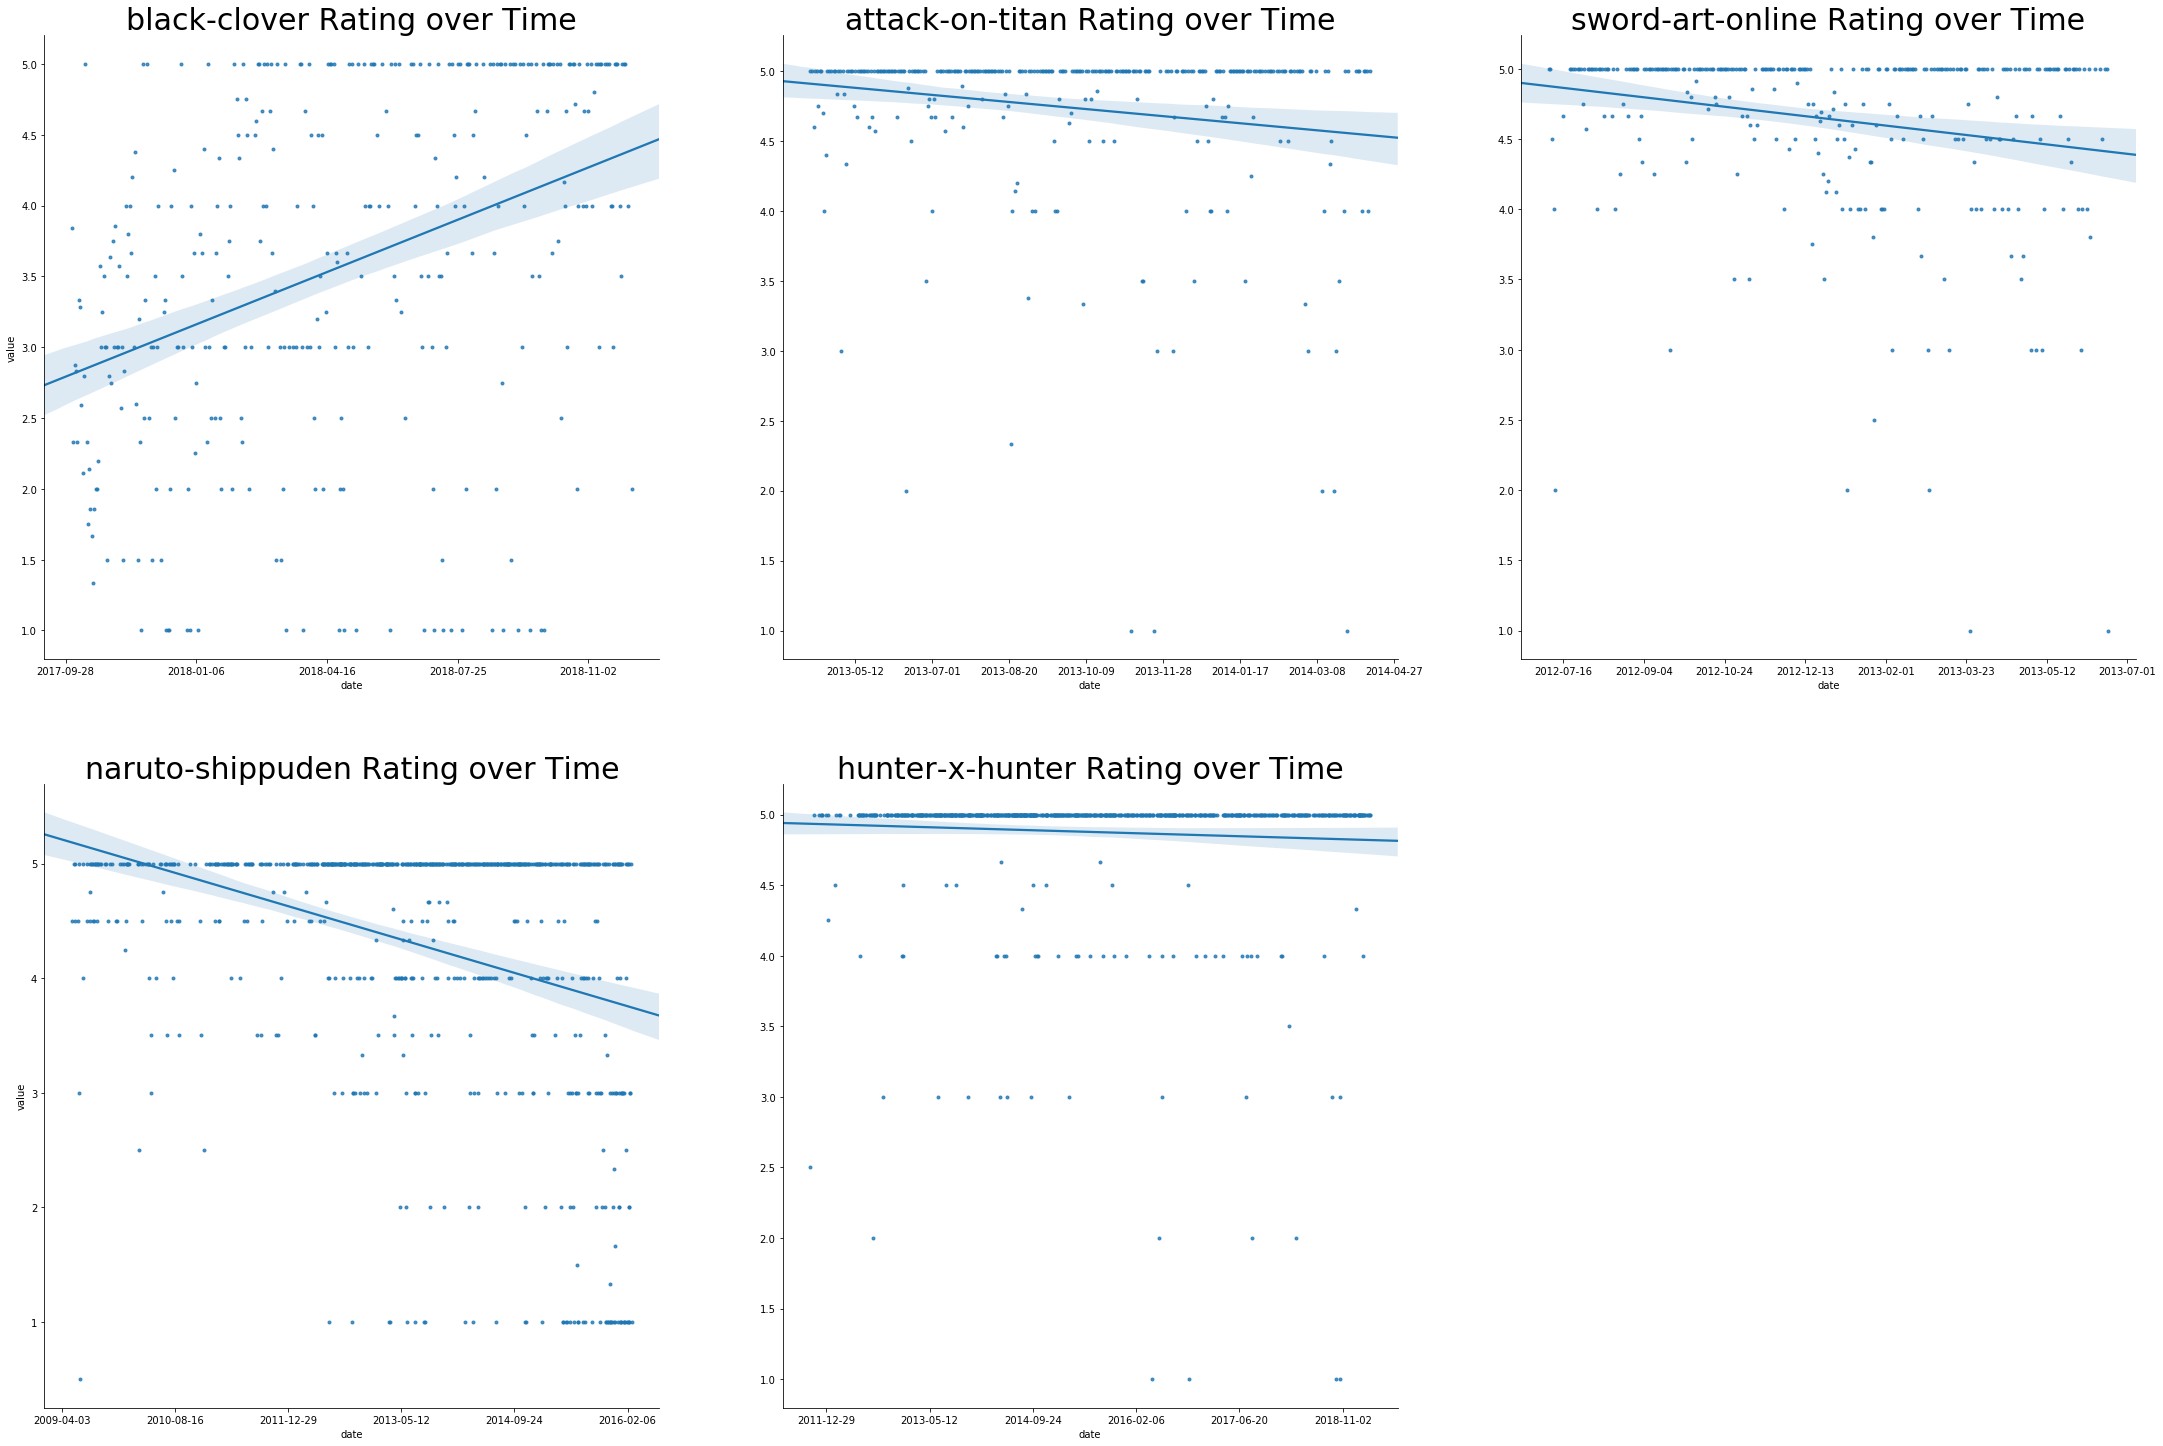

In [58]:
import matplotlib.pyplot as plt
g = sns.FacetGrid(top_5_reviews_rating_gather, 
                  col="show", 
                  col_wrap=3, 
                  height=10,
                  aspect = 1,
                  sharex = False, 
                  sharey=False)

g = g.map(sns.regplot,
          "date_ord",
          "value",
          marker = ".").set_titles("{col_name} Rating over Time",size = 30)

for ax in g.axes.flat:
    ax.set_xlabel('date')
    new_labels = [datetime.fromordinal(int(item)).date() for item in ax.get_xticks()]
    ax.set_xticklabels(new_labels)

plt.subplots_adjust(hspace=0.2, wspace=0.2)
plt.show()

It appears that Black-Clover was the only one to go up in Ratings, while the rest follow similar trends that the sentiment over time graphs imply.

### Use of a word over time

An [anime opening](https://www.youtube.com/watch?v=2uq34TeWEdQ) can be a critical part of what people enjoy in a show.

Let's see how the use of "opening" changes over time in the Crunchy Roll Reviews.

In [222]:
clean_reviews["tokens"] = tokenize(clean_reviews["review"],1,False)

review_tokens_no = clean_reviews["tokens"].apply(pd.Series) \
                .merge(clean_reviews, left_index = True, right_index = True) \
                .drop(["tokens"], axis = 1) \
                .melt(id_vars = ['show', 'datetime'], value_name = "tokens") \
                .drop("variable", axis = 1) \
                .dropna()

In [223]:
lookat = "opening"

tokens_by_time = review_tokens_no[review_tokens_no["tokens"] == lookat].pivot_table(index="datetime", 
                                           columns = "tokens", 
                                           aggfunc= ['size']).reset_index()

time_counts = pd.DataFrame(review_tokens_no["datetime"].value_counts()).rename(
                                                              columns = {"datetime":"counts"})

prop_time = tokens_by_time.merge(time_counts,
                     left_on = "datetime",
                     right_index=True)

prop_time["prop"] = prop_time[('size',lookat)] / prop_time["counts"]

prop_time["ord_datetime"] = tokens_by_time["datetime"].apply(lambda date: date.toordinal())

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/pandas/core/reshape/merge.py:544: UserWarning: merging between different levels can give an unintended result (2 levels on the left, 1 on the right)
  warnings.warn(msg, UserWarning)


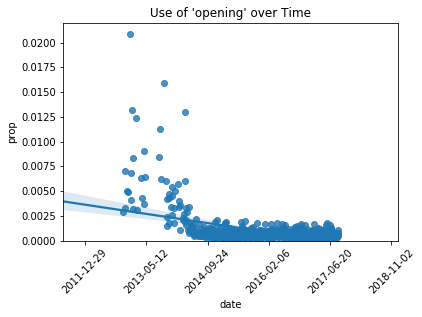

In [224]:
g = sns.regplot(x="ord_datetime",y="prop",data=prop_time)


g.set_xlabel('date')
new_labels = [datetime.fromordinal(int(item)).date() for item in ax.get_xticks()]
g.set_xticklabels(new_labels)
g.set_ylim(0,)

plt.xticks(rotation = 45)
plt.title("Use of '"+ lookat + "' over Time")
plt.show()

It appears that the word "opening" used to be a lot more used in Anime Reviews but not so much anymore.

### English Over Time

Crunchyroll has an international market, and so there are not just English Reviews. Let's explore the percentage of English Reviews over Time.

In [163]:
import enchant
d = enchant.Dict("en_US")

In [184]:
review_tokens_no["english"] = review_tokens_no["tokens"].apply(d.check)

In [185]:
review_tokens_no["english_num"] = review_tokens_no["english"].map({True : 1,False: 0})

In [190]:
english_over_time = review_tokens_no.pivot_table(index="datetime",
                             values="english_num",
                             aggfunc = np.mean).reset_index()

english_over_time["datetime_ord"] = english_over_time["datetime"].apply(lambda date: date.toordinal())

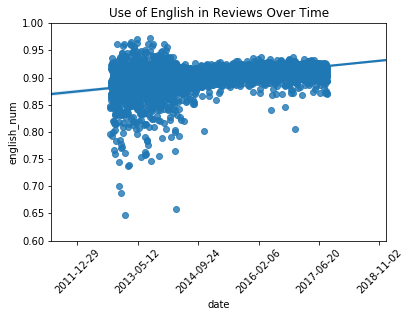

In [198]:
g = sns.regplot(x = "datetime_ord",
                y = "english_num", 
                data=english_over_time)

g.set_xlabel('date')
new_labels = [datetime.fromordinal(int(item)).date() for item in ax.get_xticks()]
g.set_xticklabels(new_labels)
g.set_ylim(0.6,1)

plt.title("Use of English in Reviews Over Time")
plt.xticks(rotation = 45)
plt.show()

It appears that there was a lot more variation in English Reviews before 2014, but it seems that as time progresses more and more reviews were in English.

## Markov Models

We wanted to try implementing Markov Models to simulate review summaries, review text, anime descriptions and names.

In [62]:
def train_uni_markov_chain(scripts):
    
    chain = {"<START>": []}
    for script in scripts:
        new_script = script.split(" ")
        chain["<START>"].append(new_script[0])
        for i in range(len(new_script)):
            if new_script[i] not in chain:
                if i == len(new_script) - 1:
                    chain[new_script[i]] = ["<END>"]
                else:
                    chain[new_script[i]] = [new_script[i+1]]
            else:
                if i == len(new_script) - 1:
                    chain[new_script[i]].append("<END>")
                else:
                    chain[new_script[i]].append(new_script[i+1])

    return chain

def generate_uni_new_script(chain):  
    
    words = []

    words.append(random.choice(chain["<START>"]))
    
    start_word = words[0]
    while start_word != "<END>":
        next_word = random.choice(chain[start_word])
        words.append(next_word)
        start_word = next_word

    lyrics = " ".join(words[:-1])
    return "\n".join(lyrics.split("<N>"))

def train_n_markov_chain(scripts, n = 2):
    initial = []
    for i in range(n):
        if i == (n - 1):
            initial.append("<START>")
        else:
            initial.append(None)
    initial = tuple(initial)
    chain = {initial: []}
    for script in scripts:
        new_scripts = script.split(" ")
        chain[initial].append(new_scripts[0])
        for i in range(len(new_scripts)):
            if len(new_scripts) > n:
                lookup = []
                for j in range(n):
                    lookup.append(new_scripts[i - n + j + 1])
                lookup = tuple(lookup)
                if i < n - 1:
                    buffer = []
                    for j in range(n - i - 2):
                        buffer.append(None)
                    if i == 0:
                        buffer.append("<START>")
                        buffer.append(new_scripts[i])
                    else:
                        buffer = list(save[1:])
                        buffer.append(new_scripts[i])
                    buffer = tuple(buffer)
                    save = buffer
                    chain[buffer] = [new_scripts[i+1]]
                elif lookup not in chain:
                    if i == len(new_scripts) - 1:
                        chain[lookup] = ["<END>"]
                    else:
                        chain[lookup] = [new_scripts[i+1]]
                else:
                    if i == len(new_scripts) - 1:
                        chain[lookup].append("<END>")
                    else:
                        chain[lookup].append(new_scripts[i+1])

    return chain

def generate_n_new_script(chain, n = 2):
    words = []
    initial = []
    for i in range(n):
        if i == (n - 1):
            initial.append("<START>")
        else:
            initial.append(None)
    initial = tuple(initial)
    words.append(random.choice(chain[initial]))
    buffer = list(initial[1:])
    buffer.append(words[-1])
    start_word = tuple(buffer)
    counter = 0
    save = []
    while "<END>" not in start_word:
        next_word = random.choice(chain[start_word])
        words.append(next_word)
        if counter <= n - 3:
            buffer = []
            for j in range(n - counter - 3):
                buffer.append(None)
            if counter == 0:
                buffer.append("<START>")
                buffer.append(words[-2])
                buffer.append(words[-1])
                start_word = tuple(buffer)
                save = start_word
            else:
                buffer = list(save[1:])
                buffer.append(words[-1])
                start_word = tuple(buffer)
                save = start_word
            counter += 1
        else:
            if n == 2:
                start_word = (words[-2],next_word)
            else:
                start_word = list(save)[1:]
                start_word.append(words[-1])
                start_word = tuple(start_word)
        save = start_word

    lyrics = " ".join(words[:-1])
    return "\n".join(lyrics.split("<N>"))

In [226]:
summary_text = reviews["summary"].str.replace("\s+", " ").str.replace("(\n|\r)","").str.strip().values
review_text = reviews["review"].str.replace("\s+", " ").str.replace("(\n|\r)","").str.strip().values

In [227]:
chain_summary = train_uni_markov_chain(summary_text)
chain_review = train_uni_markov_chain(review_text)

### Unigram Review Summary & Text

In [233]:
print(" Summary: \n",generate_uni_new_script(chain_summary),
      '\n\n',
      "Review: \n",
      generate_uni_new_script(chain_review))

 Summary: 
 A personal growth rpg type of something complete. 

 Review: 
 This show does it I high school Anime. It's very fun together, and I expected anything we saw. Naruto is smooth, it's kind of her that's only be my anime can't wait to start to leave.I really good anime right from the names so good. I have apparently closer to watch for the world not nearly lesbians ie. Naruto, One girl--rich girl who sits next five stars im into the time watching it. The pacing and I decided to do not stress along with a day to see what a must admit, I have ever recommend the animation. The intensity and i'll just right this series so I LOVED IT ps. i have put how to have so compelling aspect of all of the original story and you will make you could use today. dbz finished it develops itself about this out there, this ...


### Bigram Review Summary & Text

In [234]:
chain_summary = train_n_markov_chain(summary_text, 2)
chain_review = train_n_markov_chain(review_text, 2)

In [239]:
print(" Summary: \n",generate_n_new_script(chain_summary),
      '\n\n',
      "Review: \n",
      generate_n_new_script(chain_review))

 Summary: 
 Most memorable and not intertesting at all 

 Review: 
 This series has twelve episodes. It flows smoothly through the trees. Don't be ridiculous! But here we are. Those that are powered by the opening. In which our three central characters and they had each other's hardships. The main character with some really fun fight scenes some of the review because I like it a go? Between the Sky is written in the morals are also dynamic and interesting. I give this series (DAT), after the world’s destruction. Willem Kmetsch, the last episode, you can really get going but Zuruckspulen isn't a name plays an instrument and start wailing in despair. For me, if you haven't watched a show that can not wait for the mystery surrounding the shaved ice maker and writer ................................... AwEsOmE ....................................................................


### Unigram Anime Name & Description

In [251]:
home_text = home["desc"].str.replace("\s+", " ").str.replace("(\n|\r)","").str.strip().str.lower().values
name_values = home["name"].str.replace("\s+", " ").str.replace("(\n|\r)","").str.strip().str.lower().values

In [281]:
chain_desc = train_uni_markov_chain(home_text)
chain_name = train_uni_markov_chain(name_values)

In [289]:
print(" Anime Title:\n",generate_uni_new_script(chain_name),"\n")
print(" Anime Description:\n",generate_uni_new_script(chain_desc))

 Anime Title:
 plastic memories 

 Anime Description:
 kanae and slow start, but the conflict were wiped off of the show’s name: sana. she goes, sora and abuse, devoid of becoming a device (cad). the series by the russian blue fleet of zero f ni naru by little every day. bureikin, a beautiful ace pilots set in an entertainment career as well after the ship's computer. join shining dancing together they are naoto trains logicalists who pass on his father’s work, and aspirations seemingly utopian society is actually cupid. suddenly, junta's wildest dreams come true hero called cloths, and her fate of a high school called zai suddenly appears with the mirror city surrounded by fate of murdering a reality, she has taken up on mysterious nergal corporation, the near future to deepen their juuken club.


### Bigram Anime Name & Description

In [267]:
chain_desc = train_n_markov_chain(home_text, 2)
chain_name_ = train_n_markov_chain(name_values, 2)

In [280]:
print(" Anime Title:\n",generate_n_new_script(chain_name_),"\n")
print(" Anime Description:\n",generate_n_new_script(chain_desc))

 Anime Title:
 my teen romantic comedy snafu 

 Anime Description:
 the fleeting and sad story about you. a tale that wasn’t meant to be mourning something. his name is celestial being, and it comes to his savior, the cutely insane nino (who happens to be minori’s best friend! can this school romantic comedy that leisurely depicts the day-to-day happenings that take place in lawless, a town where friendship and find mates. over time, superhuman girls possessing special "exceed" abilities. the guy’s got a lot of unique earthlings!
